In [112]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
import jax.numpy as jnp
import numpy as onp
import pymdp.jax
from fast_structure_learning import *

In [114]:
file_name = "2.npz"
path = "../../../data/walker/run/"

res = onp.load(path + file_name)

In [115]:
res["observation"].shape

(501, 3, 64, 64)

In [116]:
!pip install -q mediapy

/usr/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
/usr/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
18089.36s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip



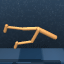

In [117]:
import mediapy

ims = [onp.transpose(res["observation"][i], (1, 2, 0)) for i in range(res["observation"].shape[0])]

with mediapy.set_show_save_dir("."):
    mediapy.show_videos({"walker": ims}, width=320, height=320, fps=20, codec='gif')

In [118]:
res["action"].shape

(501, 6)

In [119]:
res["action"][60]

array([-0.9000735 ,  0.92900676,  0.98730826,  0.9593008 , -0.8928647 ,
        1.        ], dtype=float32)

In [120]:
frames = onp.transpose(res["observation"], (0, 2, 3, 1))

In [121]:
num_frames = 128
offset = 64

frames = frames[offset:offset + num_frames]

In [122]:
frames.shape

(128, 64, 64, 3)


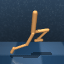

In [123]:
mediapy.show_videos({"walker": [frames[i] for i in range(frames.shape[0])]}, width=320, height=320, fps=20, codec='gif')

In [124]:
import pymdp.jax
from fast_structure_learning import *

(observations, locations_matrix, group_indices, sv_discrete_axis, V_per_patch), patch_indices = map_rgb_2_discrete(frames, tile_diameter=16, n_bins=9, sv_thr=1.0/32)
agents, RG, LB = spm_mb_structure_learning(observations, locations_matrix, max_levels=8)

Maximum probability state about factor 0 at time 0: 56
Maximum probability state about factor 0 at time 1: 27
Maximum probability state about factor 0 at time 2: 37
Maximum probability state about factor 0 at time 3: 36
Maximum probability state about factor 0 at time 4: 1
Maximum probability state about factor 0 at time 5: 0
Maximum probability state about factor 0 at time 6: 35
Maximum probability state about factor 0 at time 7: 39
Maximum probability state about factor 0 at time 8: 33
Maximum probability state about factor 0 at time 9: 38
Maximum probability state about factor 0 at time 10: 41
Maximum probability state about factor 0 at time 11: 52
Maximum probability state about factor 0 at time 12: 29
Maximum probability state about factor 0 at time 13: 40
Maximum probability state about factor 0 at time 14: 57
Maximum probability state about factor 0 at time 15: 46
Maximum probability state about factor 0 at time 16: 44
Maximum probability state about factor 0 at time 17: 47
Maxi

In [125]:
def to_img(img):
    im = jnp.transpose(img, (1, 2, 0))
    im /= 255
    im = jnp.clip(im, 0, 1)
    im = (255*im).astype(onp.uint8)
    return im


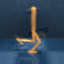

In [126]:
# generate n step predictions
one_hot = jnp.zeros([1, 32])
one_hot = one_hot.at[0, 0].set(1.0)
D = [one_hot]
E = jnp.array([[0]])
observations, beliefs = predict(agents, D, E, num_steps=10)

# convert to images
obs = observations[0]
map_discrete_2_rgb_fn = partial(map_discrete_2_rgb, locations_matrix=locations_matrix, group_indices=group_indices, sv_discrete_axis=sv_discrete_axis, V_per_patch=V_per_patch, patch_indices=patch_indices, image_shape=frames.shape[-3:])
imgs = vmap(map_discrete_2_rgb_fn, in_axes=1, out_axes=0)(obs)
imgs = imgs.reshape((imgs.shape[0]*imgs.shape[1], imgs.shape[-3], imgs.shape[-2], imgs.shape[-1]))

ims = [to_img(imgs[i]) for i in range(imgs.shape[0])]
with mediapy.set_show_save_dir("."):
    mediapy.show_videos({"generations": ims}, width=320, height=320, fps=20, codec='gif')

The resulting model has a 2 level hierarchy, printing some shapes to get some intuition...

In [127]:
len(agents)

2

In [128]:
len(agents[0].A)

273

In [129]:
agents[0].A[0].shape

(1, 9, 64)

In [130]:
len(agents[0].B)

4

In [131]:
len(agents[1].A)

8

In [132]:
len(agents[1].B)

1

In [133]:
len(observations)

2

In [134]:
observations[0].shape

(273, 22, 9)

In [135]:
observations[1].shape

(8, 11, 64)

In [136]:
len(beliefs)

2

In [137]:
beliefs[0].shape

(4, 22, 64)

In [138]:
beliefs[1].shape

(1, 11, 32)

Check if we can encode/decode all frames in the sequence using the SVD

In [140]:
all_frames = onp.transpose(res["observation"], (0, 2, 3, 1))

In [141]:
(observations, locations_matrix, group_indices, sv_discrete_axis, V_per_patch), patch_indices = map_rgb_2_discrete(all_frames, tile_diameter=16, n_bins=9, V_per_patch=V_per_patch, sv_discrete_axis=sv_discrete_axis)


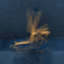

In [142]:
imgs = vmap(map_discrete_2_rgb_fn, in_axes=1, out_axes=0)(observations)
imgs = imgs.reshape((imgs.shape[0] * imgs.shape[1], imgs.shape[-3], imgs.shape[-2], imgs.shape[-1]))

ims = [to_img(imgs[i]) for i in range(imgs.shape[0])]
with mediapy.set_show_save_dir("."):
    mediapy.show_videos({"reconstructions": ims}, width=320, height=320, fps=20, codec="gif")

Let's try to infer a state from 4 new frames in the sequence


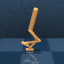

In [143]:
new_frames = all_frames[192:196]
mediapy.show_videos(
    {"test": [new_frames[i] for i in range(new_frames.shape[0])]},
    width=320,
    height=320,
    fps=2,
    codec="gif",
)

In [145]:
(observations, locations_matrix, group_indices, sv_discrete_axis, V_per_patch), patch_indices = map_rgb_2_discrete(
    new_frames, tile_diameter=16, n_bins=9, V_per_patch=V_per_patch, sv_discrete_axis=sv_discrete_axis
)

qs = infer(agents, observations, None)
print(qs)

[Array([[4.9304359e-32, 4.9304359e-32, 4.9304359e-32, 4.9304359e-32,
        4.9304359e-32, 4.9304359e-32, 4.9304359e-32, 4.9304359e-32,
        4.9304359e-32, 4.9304359e-32, 4.9304359e-32, 4.9304359e-32,
        4.9304359e-32, 4.9304359e-32, 1.0000000e+00, 4.9304359e-32,
        4.9304359e-32, 4.9304359e-32, 4.9304359e-32, 4.9304359e-32,
        2.2204415e-16, 4.9304359e-32, 4.9304359e-32, 4.9304359e-32,
        4.9304359e-32, 4.9304359e-32, 4.9304359e-32, 4.9304359e-32,
        4.9304359e-32, 4.9304359e-32, 4.9304359e-32, 4.9304359e-32]],      dtype=float32)]



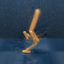

In [146]:
# reconstruct this qs
observations, beliefs = predict(agents, qs, None, num_steps=0)
obs = observations[0]
imgs = vmap(map_discrete_2_rgb_fn, in_axes=1, out_axes=0)(obs)
imgs = imgs.reshape((imgs.shape[0] * imgs.shape[1], imgs.shape[-3], imgs.shape[-2], imgs.shape[-1]))

ims = [to_img(imgs[i]) for i in range(imgs.shape[0])]
with mediapy.set_show_save_dir("."):
    mediapy.show_videos({"reconstruct_new": ims}, width=320, height=320, fps=2, codec="gif")

We can now add this to the B tensor to avoid the absorbo state

In [147]:
jnp.argmax(qs[0])

Array(14, dtype=int32)

In [148]:
print(agents[-1].B[0].shape)

(1, 32, 32, 1)


this is absorbo state, we inferred that this transitions to 14

In [149]:
agents[-1].B[0][0, :, 1, 0]

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)

In [150]:
agents[-1].B[0] = agents[-1].B[0].at[0, 14, 1, 0].set(1.0)


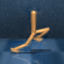

In [151]:
one_hot = jnp.zeros([1, 32])
one_hot = one_hot.at[0, 1].set(1.0)
D = [one_hot]
E = jnp.array([[0]])
observations, beliefs = predict(agents, D, E, num_steps=64)

obs = observations[0]
imgs = vmap(map_discrete_2_rgb_fn, in_axes=1, out_axes=0)(obs)
imgs = imgs.reshape((imgs.shape[0] * imgs.shape[1], imgs.shape[-3], imgs.shape[-2], imgs.shape[-1]))

ims = [to_img(imgs[i]) for i in range(imgs.shape[0])]
with mediapy.set_show_save_dir("."):
    mediapy.show_videos({"loop": ims}, width=320, height=320, fps=10, codec="gif")

We can also mask out part of the image and reconstruct the whole from inference.

In [152]:
(observations, locations_matrix, group_indices, sv_discrete_axis, V_per_patch), patch_indices = map_rgb_2_discrete(
    frames[-4:,...], tile_diameter=16, n_bins=9, V_per_patch=V_per_patch, sv_discrete_axis=sv_discrete_axis
)

print(group_indices)

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15]



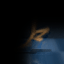

In [153]:
o_list = [observations[i] for i in range(observations.shape[0])]
for i in range(len(group_indices)):
    if group_indices[i] not in [10, 11, 14, 15]:
        o_list[i] = jnp.zeros_like(o_list[i])

masked_observations = jnp.asarray(o_list)

imgs = vmap(map_discrete_2_rgb_fn, in_axes=1, out_axes=0)(masked_observations)
imgs = imgs.reshape((imgs.shape[0] * imgs.shape[1], imgs.shape[-3], imgs.shape[-2], imgs.shape[-1]))

mims = [to_img(imgs[i]) for i in range(imgs.shape[0])]
with mediapy.set_show_save_dir("."):
    mediapy.show_videos({"masked": mims}, width=320, height=320, fps=2, codec="gif")

In [154]:
o_list = [observations[i] for i in range(observations.shape[0])]
for i in range(len(group_indices)):
    if group_indices[i] not in [10, 11, 14, 15]:
        o_list[i] = jnp.ones_like(o_list[i]) / 9

masked_observations_uniform = jnp.asarray(o_list)
print(masked_observations_uniform.shape)

(273, 2, 9)



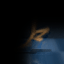
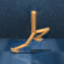

In [155]:
qs = infer(agents, masked_observations_uniform, None)
rec, _ = predict(agents, qs, None, num_steps=0)

imgs = vmap(map_discrete_2_rgb_fn, in_axes=1, out_axes=0)(rec[0])
imgs = imgs.reshape((imgs.shape[0] * imgs.shape[1], imgs.shape[-3], imgs.shape[-2], imgs.shape[-1]))

ims = [to_img(imgs[i]) for i in range(imgs.shape[0])]
with mediapy.set_show_save_dir("."):
    mediapy.show_videos({"masked": mims, "unmasked": ims}, width=320, height=320, fps=2, codec="gif")